# Sequence-to-Sequence 介紹
- 大多數常見的 **sequence-to-sequence (seq2seq) model** 為 **encoder-decoder model**，主要由兩個部分組成，分別是 **Encoder** 和 **Decoder**，而這兩個部分則大多使用 **recurrent neural network (RNN)** 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
 - **Encoder** 是將**一連串**的輸入，如文字、影片、聲音訊號等，編碼為**單個向量**，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
 - **Decoder** 是將 Encoder 輸出的單個向量逐步解碼，**一次輸出一個結果**，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束
![seq2seq](hw8_data/Encoder+DEcoder.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g. tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 湯姆 是 個 學生 。）

- TODO
  - Teachering Forcing 的功用: 嘗試不用 Teachering Forcing 做訓練
  - 實作 Attention Mechanism
  - 實作 Beam Search
  - 實作 Schedule Sampling

# 引入需要的 libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import random
import json
import heapq as pq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判斷是用 CPU 還是 GPU 執行運算

# Dataset 处理

## Dataset 结构
- Data (出自manythings 的 cmn-eng): 訓練資料：18000句；檢驗資料：  500句；測試資料： 2636句
- Dataset 格式:
  - 不同語言的句子用 TAB ('\t') 分開
  - 字跟字之間用空白分開
   > it 's none of your concern . 	這不關 你 的 事 。 <br>
   > she has a habit of bi@@ ting her na@@ ils . 	她 有 咬 指甲 的 習慣 。 <br>
   > he is a teacher . 	他 是 老師 。<br>
   > japan re@@ lies on ar@@ a@@ b countries for oil . 	日本 靠 阿拉伯 國家 提供 石油 。 <br>
   > i 'll dream about you . 	我會 夢到 你 的 。 

- 字典：
  - int2word_*.json: 將整數轉為文字
   > {"0": "<PAD>", "1": "<BOS>", "2": "<EOS>", "3": "<UNK>", "4": "。", "5": "我", "6": "的", "7": "了", "8": "你", "9": "他", "10": "？", "11": "在", "12": "是", "13": "她", "14": "湯姆", "15": "嗎", "16": "我們", "17": "，", "18": "不", "19": "有", "20": "很", "21": "什麼", "22": "去", "23": "做", "24": "說", "25": "這個", "26": "一個", "27": "知道", "28": "都", "29": "他們", "30": "喜歡", "31": "把", "32": "想", "33": "好", "34": "這", "35": "來", "36": "?", "37": "沒", 

  - word2int_*.json: 將文字轉為整數
   > {"<PAD>": 0, "<BOS>": 1, "<EOS>": 2, "<UNK>": 3, ".": 4, "i": 5, "the": 6, "to": 7, "you": 8, "a": 9, "?": 10, "is": 11, "he": 12, "n't": 13, "tom": 14, "do": 15, "in": 16, "it": 17, "'s": 18, "of": 19, "my": 20, "she": 21, "have": 22, "me": 23, "this": 24, "that": 25, ",": 26, "was": 27, "for": 28, "we": 29, "are": 30, "what": 31, "your": 32, "on": 33, "his": 34, "at": 35, "like": 36, "did": 37, "be": 38, "not": 39, "'m": 40, "with": 41, "can": 42, "her": 43, "go": 44, "there": 45, "has": 46, "will": 47, "know": 48, "him": 49, "and": 50, "want": 51, "how": 52, "very": 53, "they": 54,
  - $*$ 分為英文（en）和中文（cn）

## Dataset 轉換
將不同長度的答案拓展到相同長度，以便訓練模型

```python
numpy.pad(array, pad_width, mode = 'constant', **kwargs)
```
- **array** 表示需要填充的数组；
- **pad_width** 表示每个轴（axis）边缘需要填充的数值数目。 参数输入方式为：（(before_1, after_1), …(before_N, after_N)），其中(before_1,after_1)表示第1轴两边缘分别填充before_1个和after_1个数值。取值为：{sequence, array_like,int}
- **mode** 表示填充的方式（取值：str字符串或用户提供的函数）,总共有11种填充模式
  - ‘constant’——表示连续填充相同的值，每个轴可以分别指定填充值，constant_values=（x,y）时前面用x填充，后面用y填充，缺省值填充0
  - ‘edge’——表示用边缘值填充
  - ‘linear_ramp’——表示用边缘递减的方式填充
  - ‘maximum’——表示最大值填充
  - ‘mean’——表示均值填充
  - ‘median’——表示中位数填充
  - ‘minimum’——表示最小值填充
  - ‘reflect’——表示对称填充
  - ‘symmetric’——表示对称填充
  - ‘wrap’——表示用原数组后面的值填充前面，前面的值填充后面

In [2]:
class LabelTransform(object): # 填充
    def __init__(self, size, pad):
        self.size = size
        self.pad = pad

    def __call__(self, label):
        label = np.pad(label, (0, (self.size - label.shape[0])), mode = 'constant', constant_values = self.pad)
        return label

## 預處理 Dataset
将词转换成整数
![](hw8_data/word_to_int.png)
- 資料預處理:
  - 英文：
    - 用 subword-nmt 套件將word轉為subword
    - 建立字典：取出標籤中出現頻率高於定值的subword
  - 中文：
    - 用 jieba 將中文句子斷詞
    - 建立字典：取出標籤中出現頻率高於定值的詞
  - 特殊字元： < PAD >, < BOS >, < EOS >, < UNK > 
    - < PAD >  ：無意義，將句子拓展到相同長度
    - < BOS >  ：Begin of sentence, 開始字元
    - < EOS >  ：End of sentence, 結尾字元
    - < UNK >  ：單字沒有出現在字典裡的字
  - 將字典裡每個 subword (詞) 用一個整數表示，分為英文和中文的字典，方便之後轉為 one-hot vector   
  - 在將答案傳出去前，在答案開頭加入 "< BOS >" 符號，並於答案結尾加入 "< EOS >" 符號

In [3]:
import re
import json

class EN2CNDataset(data.Dataset): # 英文 -> 中文
    def __init__(self, path, max_output_len, set_name):
        self.path = path
        self.word2int_cn, self.int2word_cn = self.get_dictionary('cn') # 載入转换字典
        self.word2int_en, self.int2word_en = self.get_dictionary('en')
        self.data = []
        with open(self.path + set_name + '.txt', "r", encoding ='utf-8') as f: 
            for line in f:
                self.data.append(line)
        print (f'{set_name} dataset size: {len(self.data)}')
        self.cn_vocab_size = len(self.word2int_cn) # 词库大小
        self.en_vocab_size = len(self.word2int_en)
        self.transform = LabelTransform(max_output_len, self.word2int_en['<PAD>']) # 填充

    def get_dictionary(self, language): # 載入字典
        with open(self.path + 'word2int_'+ language+ '.json', "r",encoding='utf-8') as f: 
            word2int = json.load(f)
        with open(self.path + 'int2word_'+ language+ '.json', "r",encoding='utf-8') as f:
            int2word = json.load(f)
        return word2int, int2word

    def __len__(self):
        return len(self.data)

    def __getitem__(self, Index): # 获得其中一句
        sentences = self.data[Index]
        sentences = re.split('[\t\n]', sentences) # 將中英文分開
        sentences = list(filter(None, sentences)) # filter(函数, 数据源) 用函数过滤数据源，返回一个包含函数输出的迭代器，list()转换为列表
        assert len(sentences) == 2 # assert（断言）用于判断一个表达式，在表达式条件为 false 的时候触发异常
        BOS = self.word2int_en['<BOS>'] # 預備特殊字元 - 开始
        EOS = self.word2int_en['<EOS>'] # 預備特殊字元 - 结束
        UNK = self.word2int_en['<UNK>'] # 預備特殊字元 - 不在词向量里的词
        en, cn = [BOS], [BOS] # 在開頭添加 <BOS>，在結尾添加 <EOS> ，不在字典的 subword (詞) 用 <UNK> 取代
    
        # 处理英文
        sentence = re.split(' ', sentences[0]) # 將句子拆解為 subword 並轉為整數，空格分隔
        sentence = list(filter(None, sentence))
        for word in sentence: # 英文word 变成向量
            en.append(self.word2int_en.get(word, UNK))
        en.append(EOS) # 結尾添加 <EOS>
    
        # 处理中文
        sentence = re.split(' ', sentences[1]) # 將句子拆解為單詞並轉為整數
        sentence = list(filter(None, sentence))
        for word in sentence:
            cn.append(self.word2int_cn.get(word, UNK))
        cn.append(EOS)

        en, cn = np.asarray(en), np.asarray(cn)
        # 用 <PAD> 將句子補到相同長度
        en, cn = self.transform(en), self.transform(cn)
        en, cn = torch.LongTensor(en), torch.LongTensor(cn)

        return en, cn

# 模型架構
![](hw8_data/总model图.png)

## Encoder
- seq2seq模型的編碼器為RNN。 對於每個輸入，**Encoder** 會輸出**一個向量**和**一個隱藏狀態(hidden state)**，並將隱藏狀態用於下一個輸入，換句話說，**Encoder** 會逐步讀取輸入序列，並輸出單個矢量（最終隱藏狀態）
- 參數:
  - **en_vocab_size** 英文词库的大小，也就是英文的 subword 的個數
  - **emb_dim** embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - **hid_dim** RNN 輸出和隱藏狀態的維度
  - **n_layers** RNN 要疊多少層
  - **dropout** 決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
- Encoder 的輸入和輸出:
  - 輸入: 
    - 英文的整數序列 e.g. 1, 28, 29, 205, 2
  - 輸出: 
    - outputs: 最上層 RNN 全部的輸出，可以用 Attention 再進行處理
    - hidden: 每層最後的隱藏狀態，將傳遞到 Decoder 進行解碼
![](hw8_data/Encoder.png)

In [4]:
class Encoder(nn.Module): # 将用来表示词的整数转换成 词向量
    def __init__(self, en_vocab_size, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(en_vocab_size, emb_dim)
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first = True, bidirectional = True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        embedding = self.embedding(input) # input[batch size, sequence len, vocab size]
        outputs, hidden = self.rnn(self.dropout(embedding))
        # outputs = [batch size, sequence len, hid dim * directions] 单向directions = 1，双向directions = 2，两个向量接起来
        # hidden =  [num_layers * directions, batch size, hid dim]
        # outputs 是最上層RNN的輸出，最终的输出
        return outputs, hidden

## Decoder
- **Decoder** 是另一個 RNN，在最簡單的 seq2seq decoder 中，僅使用 **Encoder** 每一層最後的隱藏狀態來進行解碼，而這最後的隱藏狀態有時被稱為 “content vector”，因為可以想像它對整個前文序列進行編碼， 此 “content vector” 用作 **Decoder** 的**初始**隱藏狀態， 而 **Encoder** 的輸出通常用於 Attention Mechanism
- 參數:
  - **en_vocab_size** 英文词库的大小，也就是英文的 subword 的個數
  - **emb_dim** embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - **hid_dim** RNN 輸出和隱藏狀態的維度
  - **n_layers** RNN 要疊多少層
  - **dropout** 決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - **isatt** 是來決定是否使用 Attention Mechanism

- Decoder 的輸入和輸出:
  - 輸入:
    - 前一次解碼出來的單詞的整數表示
  - 輸出:
    - hidden: 根據輸入和前一次的隱藏狀態，現在的隱藏狀態更新的結果
    - output: 每個字有多少機率是這次解碼的結果
![](hw8_data/Decoder.png)

In [5]:
class Decoder(nn.Module):
    def __init__(self, cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
        super().__init__()
        self.cn_vocab_size = cn_vocab_size
        self.hid_dim = hid_dim * 2 # 编码时正向、反向各一个向量，两个向量接起来，维度 * 2
        self.n_layers = n_layers
        self.embedding = nn.Embedding(cn_vocab_size, config.emb_dim)
        self.isatt = isatt
        self.attention = Attention(hid_dim)
        # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
        # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
        # self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
        self.input_dim = emb_dim
        if isatt == False: # 根据是否执行相关性计算，决定输入维度
             self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
        else:
             self.rnn = nn.GRU((emb_dim + hid_dim*2), self.hid_dim, n_layers, dropout= dropout, batch_first=True)
        self.embedding2vocab1 = nn.Linear(self.hid_dim, self.hid_dim * 2)
        self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
        self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.cn_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # hidden = [batch size, n layers * directions, hid dim]
        # Decoder 只會是單向，所以 directions = 1
        input = input.unsqueeze(1) # input[batch size, vocab size] 变成一行
        embedded = self.dropout(self.embedding(input)) # embedded [batch size, 1, emb dim]
        if self.isatt:# 在這裡決定如何使用 Attention，e.g. 相加 或是 接在後面， 請注意維度變化
            attn = self.attention(encoder_outputs, hidden) 
            attn = attn.unsqueeze(1)
            weighted = torch.bmm(attn, encoder_outputs)
            rnn_input = torch.cat((embedded, weighted), dim=2)
            output, hidden = self.rnn(rnn_input, hidden)
        else:
            output, hidden = self.rnn(embedded, hidden) # output[batch size, 1, hid dim]， hidden[num_layers, batch size, hid dim]
        # 將 RNN 的輸出轉為每個詞出現的機率
        output = self.embedding2vocab1(output.squeeze(1))
        output = self.embedding2vocab2(output)
        prediction = self.embedding2vocab3(output) # prediction[batch size, vocab size]
        return prediction, hidden

## Attention
- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 **Decoder** 更多的資訊
- 主要是根據現在 **Decoder hidden state** ，去計算在 **Encoder outputs** 中，那些词与词之间联系的强弱關系，關系的數值是傳給 **Decoder** 額外的資訊 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **Decoder hidden state** 和 **Encoder outputs** 之間的關係，再對所有算出來的數值做 **softmax** ，最後根據過完 **softmax** 的值對 **Encoder outputs** 做 **weight sum**
- 一般來說是取 Encoder 最後一層的 hidden state 來做 attention

In [6]:
'''
class Attention(nn.Module): # 词与词之间联系的强弱關系
    def __init__(self, hid_dim): 
        super(Attention, self).__init__()
        self.hid_dim = hid_dim
        self.device = device
        self.match_nn = nn.Sequential( # match 网络是有2层 hidden layer 的 神经网络
            nn.Linear(self.hid_dim * 2, self.hid_dim * 4),
            nn.Linear(self.hid_dim * 4, self.hid_dim * 2),
            nn.Linear(self.hid_dim * 2, 1))
    
    def match(self, h, z):
        alpha = self.match_nn(torch.cat((h, z), dim=1)) # 将矩阵 h, z 左右拼接
        return alpha
  
    def forward(self, encoder_outputs, decoder_hidden):
        # encoder_outputs[batch size, sequence len, hid dim * directions]
        # decoder_hidden[num_layers, batch size, hid dim]
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # 将 tensor 转置
        sequence_len = encoder_outputs.shape[0] # 句子长度
        batch_size = encoder_outputs.shape[1]
        alphas = torch.zeros(sequence_len, batch_size).to(self.device) # 相关性的矩阵，每个元素装一个词的相关性矩阵
        for i in range(sequence_len):
            h = encoder_outputs[i] # 一个词的词向量
            z = decoder_hidden[-1] #  Encoder 最後一層的 hidden state，包含所有词的信息
            alpha = self.match(h, z).squeeze() # 去掉维度为 1 的维度，使矩阵维度 -1 e.g. [[1,2]] -> [1,2]
            alphas[i] = alpha
        alphas = alphas.softmax(dim = 0)
        attention = torch.zeros(batch_size, self.hid_dim).to(self.device)
        for i in range(sequence_len):
            alpha = alphas[i].unsqueeze(1) # 第二维增加一个维度 e.g. [[1,2],[3,4]] -> [[[1,2]],[[3,4]]
            h = encoder_outputs[i]
            attention = attention + h * alpha # 做weigh sum
        return attention
        '''

'\nclass Attention(nn.Module): # 词与词之间联系的强弱關系\n    def __init__(self, hid_dim): \n        super(Attention, self).__init__()\n        self.hid_dim = hid_dim\n        self.device = device\n        self.match_nn = nn.Sequential( # match 网络是有2层 hidden layer 的 神经网络\n            nn.Linear(self.hid_dim * 2, self.hid_dim * 4),\n            nn.Linear(self.hid_dim * 4, self.hid_dim * 2),\n            nn.Linear(self.hid_dim * 2, 1))\n    \n    def match(self, h, z):\n        alpha = self.match_nn(torch.cat((h, z), dim=1)) # 将矩阵 h, z 左右拼接\n        return alpha\n  \n    def forward(self, encoder_outputs, decoder_hidden):\n        # encoder_outputs[batch size, sequence len, hid dim * directions]\n        # decoder_hidden[num_layers, batch size, hid dim]\n        encoder_outputs = encoder_outputs.permute(1, 0, 2) # 将 tensor 转置\n        sequence_len = encoder_outputs.shape[0] # 句子长度\n        batch_size = encoder_outputs.shape[1]\n        alphas = torch.zeros(sequence_len, batch_size).to(self.device) #

In [6]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super(Attention, self).__init__()
        self.hid_dim = hid_dim
        self.attn = nn.Linear((hid_dim * 2) + (hid_dim * 2), hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias = False)
  
    def forward(self, encoder_outputs, decoder_hidden):
        # encoder_outputs = [batch size, sequence len, hid dim * directions]
        # decoder_hidden = [num_layers, batch size, hid dim]
        # 一般來說是取 Encoder 最後一層的 hidden state 來做 attention
        # num_layers = 3
        src_len = encoder_outputs.shape[1]
        decoder_hidden = decoder_hidden[0] + decoder_hidden[1] + decoder_hidden[2]
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((encoder_outputs, decoder_hidden), dim = 2)))
        attention = self.v(energy).squeeze(2)
    
        return F.softmax(attention, dim = 1)

## Seq to Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- 不斷地將 **Decoder** 的輸出傳回 **Decoder** ，進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.n_layers == decoder.n_layers,  "Encoder and decoder must have equal number of layers!"
            
    def forward(self, input, target, teacher_forcing_ratio): # teacher_forcing_ratio 是有多少機率使用正確答案來訓練
        # input[batch size, input len, vocab size]， target[batch size, target len, vocab size]
        batch_size = target.shape[0]
        target_len = target.shape[1]
        vocab_size = self.decoder.cn_vocab_size
        
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device) # 準備一個儲存空間來儲存輸出
        encoder_outputs, hidden = self.encoder(input) # 將輸入放入 Encoder
        # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder， encoder_outputs 主要是使用在 Attention
        # Encoder 是雙向的RNN hidden[num_layers * directions, batch size, hid dim]  --> [num_layers, directions, batch size, hid dim]
        hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1) # 转换矩阵形状
        hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2) # 拼接矩阵
        input = target[:, 0] # 取的 <BOS> token
        preds = []
        for t in range(1, target_len): # <BOS> 不用分析
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() <= teacher_forcing_ratio # 決定是否用正確答案來做訓練
            top1 = output.argmax(1) # 取出機率最大的單詞
            # 如果是 teacher force 則用正解訓練，反之用自己預測的單詞做預測
            input = target[:, t] if teacher_force and t < target_len else top1
            preds.append(top1.unsqueeze(1))
        preds = torch.cat(preds, 1)
        return outputs, preds

    def inference(self, input, target): # 在這裡實施 Beam Search,Beam Search以heapq實現
        # 此函式的 batch size = 1  
        # input  = [batch size, input len, vocab size]
        # target = [batch size, target len, vocab size]
        batch_size = input.shape[0]
        input_len = input.shape[1] # 取得最大字數
        vocab_size = self.decoder.cn_vocab_size
        # 準備一個儲存空間來儲存輸出
        outputs = torch.zeros(batch_size, input_len, vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(input) # 將輸入放入 Encoder
        # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
        # encoder_outputs 主要是使用在 Attention
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
        hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1) # 重构张量的维度
        hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2) # 拼接
        input = target[:, 0] # 取的 <BOS> token
        if BEAM_SEARCH == False:
            preds = [] # 用来存结果
            for t in range(1, input_len):
                output, hidden = self.decoder(input, hidden, encoder_outputs)
                outputs[:, t] = output # 將預測結果存起來
                top1 = output.argmax(1) # 取出機率最大的單詞
                input = top1
                preds.append(top1.unsqueeze(1))
            preds = torch.cat(preds, 1)
            return outputs, preds
        else:
            if BEAM_WIDTH <= 1:
                print('BEAM_WIDTH <= 1 !!')
            preds = []
            for t in range(1, input_len):
                if t == 1:
                    output, hidden = self.decoder(input, hidden, encoder_outputs)
                    outputs[:,t] = output
                    output = F.log_softmax(output, dim = 1)
                    log_prob, indexs = torch.topk(output, BEAM_WIDTH)
                    for k, (log_p, idx) in enumerate(zip(log_prob[0], indexs[0])):
                        idx = idx.view(1)
                        pq.heappush(preds, [-log_p.clone().item(), [idx], hidden.clone(), outputs.clone()])
                else:
                    temp = []
                    for i in range(BEAM_WIDTH):
                        cur_p, cur_tokens, cur_hidden, cur_outputs = preds[i]
                        input = cur_tokens[-1]
                        output, cur_hidden = self.decoder(input, cur_hidden, encoder_outputs)
                        cur_outputs[:,t] = output
                        output = F.log_softmax(output, dim = 1)
                        log_prob, indexs = torch.topk(output, BEAM_WIDTH)
                        for j, (log_p, idx) in enumerate(zip(log_prob[0], indexs[0])):
                            temp_p = cur_p
                            idx = idx.view(1)
                            tmp_token = cur_tokens + [idx]
                            temp_p -= log_p.item()
                            pq.heappush(temp, [temp_p, tmp_token, cur_hidden.clone(), cur_outputs.clone()])
                    preds = [pq.heappop(temp) for i in range(BEAM_WIDTH)]
                    del temp
            preds = pq.heappop(preds)
            _, preds, _, outputs= preds
            preds = torch.LongTensor(preds).view(1, len(preds))
            return outputs, preds


# utils
- 基本操作:
  - 儲存模型
  - 載入模型
  - 建構模型
  - 將一連串的數字還原回句子
  - 計算 BLEU score
  - 迭代 dataloader

## 儲存模型

In [8]:
def save_model(model, optimizer, store_model_path, step):
    model_name = store_model_path + 'model_' + str(step) + '.ckpt'
    torch.save(model.state_dict(), model_name)
    return

## 載入模型

In [9]:
def load_model(model, load_model_path): # 将参数放入 model 中
    print(f'Load model from {load_model_path}')
    model.load_state_dict(torch.load(load_model_path + '.ckpt')) # 需要钦定 mode 的名字
    return model

## 建構模型

In [10]:
def build_model(config, en_vocab_size, cn_vocab_size):
    # 建構模型
    encoder = Encoder(en_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
    decoder = Decoder(cn_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout, config.attention)
    model = Seq2Seq(encoder, decoder, device)
    print(model)
    
    # 建構 optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    print(optimizer)
    if config.load_model: # 将参数放入 model 中
        model = load_model(model, config.load_model_path)
    model = model.to(device)

    return model, optimizer

## 數字轉句子

In [11]:
def tokens2sentence(outputs, int2word):
    sentences = []
    for tokens in outputs:
        sentence = []
        for token in tokens:
            word = int2word[str(int(token))]
            if word == '<EOS>':
                break
            sentence.append(word)
        sentences.append(sentence)
    return sentences

## 計算 BLEU score

In [12]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
    score = 0 
    assert (len(sentences) == len(targets))
    def cut_token(sentence):
        tmp = []
        for token in sentence:
            if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp 

    for sentence, target in zip(sentences, targets):
        sentence = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
    return score

## 迭代 dataloader

In [13]:
def infinite_iter(data_loader):
    it = iter(data_loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(data_loader)

## schedule_sampling

In [14]:
#選擇使用 Linear, Exponential, Inverse Sigmoid實現
def schedule_sampling(step, t_step, mode):
    try:
        mode, h_para = mode
    except:
        mode = MODE[0]
    
    if mode == 'Naive':
        return TEACHER_FORCE_RATE
    elif mode == 'Linear':
        decrement = 1/t_step
        return 1- decrement * step
    elif mode == 'Exponential': # 0.999 
        return h_para**step
    elif mode == 'Inverse_Sigmoid':
        return h_para / (h_para + np.exp(step/h_para)) # 800

# 訓練步驟

## 訓練

In [15]:
def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
    model.train()
    model.zero_grad()
    losses = []
    loss_sum = 0.0
    for step in range(summary_steps):
        now_tf = schedule_sampling(total_steps + step, config.num_steps, MODE)
        sources, targets = next(train_iter)
        sources, targets = sources.to(device), targets.to(device)
        outputs, preds = model(sources, targets, now_tf)
        # targets 的第一個 token 是 <BOS> 所以忽略
        outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
        targets = targets[:, 1:].reshape(-1)
        loss = loss_function(outputs, targets)
    
        optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss_sum += loss.item()
        if (step + 1) % 5 == 0:
            loss_sum = loss_sum / 5
            print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}, teach: {:.3f}".format(total_steps + step + 1, loss_sum, np.exp(loss_sum), now_tf), end=" ")
            losses.append(loss_sum)
            loss_sum = 0.0

    return model, optimizer, losses

## 檢驗/測試
防止訓練發生overfitting

In [16]:
def test(model, dataloader, loss_function):
    model.eval()
    loss_sum, bleu_score= 0.0, 0.0
    n = 0
    result = []
    for sources, targets in dataloader:
        sources, targets = sources.to(device), targets.to(device)
        batch_size = sources.size(0)
        outputs, preds = model.inference(sources, targets)
        # targets 的第一個 token 是 <BOS> 所以忽略
        outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
        targets = targets[:, 1:].reshape(-1)

        loss = loss_function(outputs, targets)
        loss_sum += loss.item()

        # 將預測結果轉為文字
        targets = targets.view(sources.size(0), -1)
        preds = tokens2sentence(preds, dataloader.dataset.int2word_cn)
        sources = tokens2sentence(sources, dataloader.dataset.int2word_en)
        targets = tokens2sentence(targets, dataloader.dataset.int2word_cn)
        for source, pred, target in zip(sources, preds, targets):
            result.append((source, pred, target))
        bleu_score += computebleu(preds, targets) # 計算 Bleu Score
    n += batch_size
    return loss_sum / len(dataloader), bleu_score / n, result

## 訓練流程
先訓練，再檢驗

In [17]:
def train_process(config):
    # 準備訓練資料
    train_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'training')
    train_loader = data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    train_iter = infinite_iter(train_loader)
    # 準備檢驗資料
    val_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'validation')
    val_loader = data.DataLoader(val_dataset, batch_size = 1)
    # 建構模型
    model, optimizer = build_model(config, train_dataset.en_vocab_size, train_dataset.cn_vocab_size)
    loss_function = nn.CrossEntropyLoss(ignore_index = 0)

    train_losses, val_losses, bleu_scores = [], [], []
    total_steps = 0
    
    tf = []
    print('Now teacher forcing setting plot')
    for i in range(config.num_steps):
        tf.append(schedule_sampling(i, config.num_steps, MODE))
    plt.plot(range(config.num_steps), tf)
    plt.title('teacher forcing schedule')
    plt.show()
    
    while (total_steps < config.num_steps):
        # 訓練模型
        model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset)
        train_losses += loss
        # 檢驗模型
        val_loss, bleu_score, result = test(model, val_loader, loss_function)
        val_losses.append(val_loss)
        bleu_scores.append(bleu_score)

        total_steps += config.summary_steps
        print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}"  .format(total_steps, val_loss, np.exp(val_loss), bleu_score))
    
        # 儲存模型和結果
        if total_steps % config.store_steps == 0 or total_steps >= config.num_steps:
            save_model(model, optimizer, config.store_model_path, total_steps)
            with open(config.store_model_path + 'output_'  + str(total_steps) + '.txt', 'w', encoding='utf-8') as f:
                for line in result:
                        print (line, file = f)
    
    return train_losses, val_losses, bleu_scores

## 測試流程

In [18]:
def test_process(config):
    # 準備測試資料
    test_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'testing')
    test_loader = data.DataLoader(test_dataset, batch_size=1)
    # 建構模型
    model, optimizer = build_model(config, test_dataset.en_vocab_size, test_dataset.cn_vocab_size)
    print ("Finish build model")
    loss_function = nn.CrossEntropyLoss(ignore_index = 0)
    model.eval() # 測試模型
    test_loss, bleu_score, result = test(model, test_loader, loss_function)
    with open('hw8_data/test_output.txt', 'w', encoding='utf-8') as f: # 儲存結果
        for line in result:
            print (line, file = f)
    return test_loss, bleu_score

# Config

In [20]:
class configurations(object):
    def __init__(self):
        self.batch_size = 60
        self.emb_dim = 256
        self.hid_dim = 512
        self.n_layers = 3
        self.dropout = 0.5
        self.learning_rate = 0.00005
        self.max_output_len = 50              # 最後輸出句子的最大長度
        self.num_steps = 10000              # 總訓練次數
        self.store_steps = 1500                # 訓練多少次後須儲存模型
        self.summary_steps = 1500              # 訓練多少次後須檢驗是否有overfitting
        self.load_model = False               # 是否需載入模型
        self.store_model_path = "hw8_data/model/"      # 儲存模型的位置
        self.load_model_path = None           # 載入模型的位置 e.g. "hw8_data/model/model_{step}" 
        self.data_path = "hw8_data/"          # 資料存放的位置
        self.attention = True                # 是否使用 Attention Mechanism

# Main Function
讀入參數
進行訓練或是推論

## train

config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 10000, 'store_steps': 1500, 'summary_steps': 1500, 'load_model': False, 'store_model_path': 'hw8_data/model/', 'load_model_path': None, 'data_path': 'hw8_data/', 'attention': True}
training dataset size: 18000
validation dataset size: 500
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention(
      (attn): Linear(in_features=2048, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2vocab2): Lin

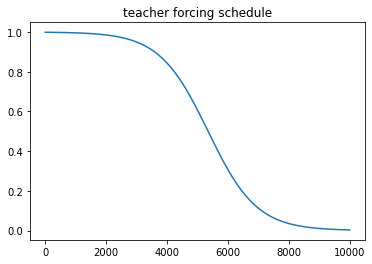

 train [1500] loss: 3.665, Perplexity: 39.053, teach: 0.992 

C:\Anaconda3\envs\ML\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda3\envs\ML\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda3\envs\ML\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

 val [1500] loss: 5.347, Perplexity: 210.045, blue score: 164.661
 val [3000] loss: 4.706, Perplexity: 110.573, blue score: 184.194
 val [4500] loss: 3.880, Perplexity: 48.414, blue score: 204.807
 val [6000] loss: 3.407, Perplexity: 30.188, blue score: 215.159
 val [7500] loss: 3.340, Perplexity: 28.221, blue score: 220.252
 train [7510] loss: 2.737, Perplexity: 15.438, teach: 0.063 

In [ ]:
BEAM_SEARCH = False
BEAM_WIDTH = 3
# TEACHER_FORCE_RATE = 0.5
# MODE = ['Linear']
# MODE = ['Exponential', 0.999]
MODE = ['Inverse_Sigmoid', 800]

import time
# 在執行 Test 之前，請先行至 config 設定所要載入的模型位置
if __name__ == '__main__':
    #input_path = sys.argv[1]
    start = time.time()
    config = configurations()
    print ('config:\n', vars(config))
    test_loss, bleu_score = train_process(config)
    print('time used: ' + str(time.time() - start))

# 圖形化訓練過程

## 以圖表呈現 **訓練** 的 loss 變化趨勢

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## 以圖表呈現 **檢驗** 的 loss 變化趨勢

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

In [ ]:
val_losses

## BLEU score

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bleu_scores)
plt.xlabel('次數')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()